## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果。

#### 注意：前處理若只是簡單的平移、旋轉、縮放等，不需預設資料為 0 ~ 255 的整數。

## 參考資料

[图片数据集太少？看我七十二变：Keras Image Data Augmentation 各参数详解](https://zhuanlan.zhihu.com/p/30197320)

In [1]:
import math
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 10)


## 定義函數

In [6]:
def image_generator(x, y, generator_param, batch_size=32):
    generator = ImageDataGenerator(
        fill_mode='constant',
        horizontal_flip=True,
        zoom_range=generator_param.zoom_range,
        shear_range=generator_param.shear_range,
        rotation_range=generator_param.rotation_range)
    return generator.flow(x, y, batch_size=batch_size)

class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, generator_param, epochs=50, batch_size=128, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.generator_param = generator_param
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        return RMSprop(lr=self.learning_rate)

    @property
    def generator(self):
        return image_generator(*self.train_data, self.generator_param, self.batch_size)

    @property
    def train_data(self):
        return (self.X_train, self.y_train,)

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        backend.set_session(tf.Session(config=tf.ConfigProto(
            device_count = {'CPU': 2, 'GPU': 0},
            allow_soft_placement = True,
            inter_op_parallelism_threads = 2,
            intra_op_parallelism_threads = 2)))
        self._model = None
        return self

    def _build(self):
        model = self._model = Sequential()
        model.add(Conv2D(32, (3, 3,), input_shape=self.X_train.shape[1:]))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.15))
        model.add(Conv2D(64, (3, 3,)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3,)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2,)))
        model.add(Dropout(0.15))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dropout(0.10))
        model.add(Dense(self.y_train.shape[-1]))
        model.add(Activation('softmax'))
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with label: {}'.format(self.generator_param.label))
        self._model.summary()
        self._history = self._model.fit_generator(
            self.generator, epochs=self.epochs, steps_per_epoch=int(math.ceil(self.X_train.shape[0] / self.batch_size)),
            validation_data=self.validation_data, verbose=2)
        return self

    def display(self, train_name, val_name, color):
        plt.plot(self._history.history[train_name], '-', label='exp: {}'.format(self.generator_param.label), color=color)
        plt.plot(self._history.history[val_name], '--', label='exp: {}'.format(self.generator_param.label), color=color)

class GeneratorParam:

    def __init__(self, zoom_range, shear_range, rotation_range):
        self.zoom_range = zoom_range
        self.shear_range = shear_range
        self.rotation_range = rotation_range

    @property
    def label(self):
        return 'zr={:.1f}, sr={:.1f}, rr={}'.format(self.zoom_range, self.shear_range, self.rotation_range)

class BatchTrainer:
    
    def __init__(self, trainers):
        self.trainers = trainers
        self.total_amount = len(trainers)

    @property
    def colors(self):
        color_map = cm.ScalarMappable(cmap=plt.get_cmap('gist_rainbow'),
                                      norm=colors.Normalize(vmin=0, vmax=self.total_amount - 1))
        return [color_map.to_rgba(i) for i in range(self.total_amount)]

    def run(self):
        for i in range(self.total_amount):
            self.trainers[i].run()
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(12, 7,))
        for i, color in enumerate(self.colors):
            self.trainers[i].display(train_name, val_name, color)
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5,))
        plt.show()

## 以不同的影像生成參數觀看學習曲線的走勢

In [7]:
# 設定超參數
zoom_ranges = [0.1, 0.3, 0.5]
shear_ranges = [0.1, 0.3, 0.5]
rotation_ranges = [10, 30, 50]

params = [GeneratorParam(zoom_range, shear_range, rotation_range) for zoom_range, shear_range, rotation_range
          in itertools.product(zoom_ranges, shear_ranges, rotation_ranges)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [8]:
batch_trainer = BatchTrainer(trainers).run()

Experiment with label: zr=0.1, sr=0.1, rr=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (N

Epoch 1/50
 - 180s - loss: 1.8657 - acc: 0.3232 - val_loss: 1.4845 - val_acc: 0.4652
Epoch 2/50
 - 179s - loss: 1.4970 - acc: 0.4642 - val_loss: 1.3742 - val_acc: 0.5079
Epoch 3/50
 - 179s - loss: 1.3313 - acc: 0.5284 - val_loss: 1.1720 - val_acc: 0.5837
Epoch 4/50
 - 178s - loss: 1.2144 - acc: 0.5740 - val_loss: 1.1264 - val_acc: 0.6051
Epoch 5/50
 - 178s - loss: 1.1304 - acc: 0.6036 - val_loss: 0.9876 - val_acc: 0.6525
Epoch 6/50
 - 178s - loss: 1.0547 - acc: 0.6320 - val_loss: 0.9441 - val_acc: 0.6698
Epoch 7/50
 - 179s - loss: 0.9991 - acc: 0.6554 - val_loss: 1.0062 - val_acc: 0.6679
Epoch 8/50
 - 179s - loss: 0.9442 - acc: 0.6715 - val_loss: 0.9210 - val_acc: 0.6879
Epoch 9/50
 - 178s - loss: 0.8960 - acc: 0.6895 - val_loss: 0.8491 - val_acc: 0.7149
Epoch 10/50
 - 178s - loss: 0.8599 - acc: 0.7044 - val_loss: 0.9823 - val_acc: 0.6701
Epoch 11/50
 - 178s - loss: 0.8288 - acc: 0.7138 - val_loss: 0.9344 - val_acc: 0.6902
Epoch 12/50
 - 178s - loss: 0.8044 - acc: 0.7219 - val_loss: 0.

Epoch 12/50
 - 228s - loss: 0.9220 - acc: 0.6789 - val_loss: 0.8196 - val_acc: 0.7186
Epoch 13/50
 - 226s - loss: 0.9049 - acc: 0.6863 - val_loss: 1.0261 - val_acc: 0.6665
Epoch 14/50
 - 225s - loss: 0.8814 - acc: 0.6948 - val_loss: 0.9925 - val_acc: 0.6738
Epoch 15/50
 - 226s - loss: 0.8669 - acc: 0.7010 - val_loss: 0.9466 - val_acc: 0.6927
Epoch 16/50
 - 226s - loss: 0.8485 - acc: 0.7061 - val_loss: 0.8141 - val_acc: 0.7229
Epoch 17/50
 - 226s - loss: 0.8341 - acc: 0.7121 - val_loss: 0.8315 - val_acc: 0.7245
Epoch 18/50
 - 226s - loss: 0.8168 - acc: 0.7184 - val_loss: 0.8128 - val_acc: 0.7302
Epoch 19/50
 - 225s - loss: 0.8068 - acc: 0.7199 - val_loss: 0.8105 - val_acc: 0.7339
Epoch 20/50
 - 223s - loss: 0.7980 - acc: 0.7256 - val_loss: 0.9151 - val_acc: 0.7077
Epoch 21/50
 - 223s - loss: 0.7911 - acc: 0.7262 - val_loss: 0.9450 - val_acc: 0.7108
Epoch 22/50
 - 228s - loss: 0.7841 - acc: 0.7291 - val_loss: 0.7920 - val_acc: 0.7350
Epoch 23/50
 - 227s - loss: 0.7763 - acc: 0.7345 - val

Epoch 23/50
 - 180s - loss: 0.5051 - acc: 0.8265 - val_loss: 0.6740 - val_acc: 0.7910
Epoch 24/50
 - 180s - loss: 0.4911 - acc: 0.8323 - val_loss: 0.6923 - val_acc: 0.7822
Epoch 25/50
 - 182s - loss: 0.4985 - acc: 0.8311 - val_loss: 0.7497 - val_acc: 0.7820
Epoch 26/50
 - 180s - loss: 0.4889 - acc: 0.8360 - val_loss: 0.6823 - val_acc: 0.7848
Epoch 27/50
 - 179s - loss: 0.4820 - acc: 0.8371 - val_loss: 0.8427 - val_acc: 0.7679
Epoch 28/50
 - 179s - loss: 0.4774 - acc: 0.8386 - val_loss: 0.7155 - val_acc: 0.7773
Epoch 29/50
 - 179s - loss: 0.4740 - acc: 0.8386 - val_loss: 0.7207 - val_acc: 0.7719
Epoch 30/50
 - 180s - loss: 0.4678 - acc: 0.8417 - val_loss: 0.9372 - val_acc: 0.7409
Epoch 31/50
 - 179s - loss: 0.4697 - acc: 0.8424 - val_loss: 0.7503 - val_acc: 0.7700
Epoch 32/50
 - 179s - loss: 0.4634 - acc: 0.8430 - val_loss: 0.7416 - val_acc: 0.7821
Epoch 33/50
 - 180s - loss: 0.4705 - acc: 0.8408 - val_loss: 0.7809 - val_acc: 0.7685
Epoch 34/50
 - 180s - loss: 0.4645 - acc: 0.8415 - val

Epoch 34/50
 - 178s - loss: 0.6113 - acc: 0.7922 - val_loss: 1.0033 - val_acc: 0.7295
Epoch 35/50
 - 179s - loss: 0.6204 - acc: 0.7898 - val_loss: 0.6621 - val_acc: 0.7864
Epoch 36/50
 - 179s - loss: 0.6122 - acc: 0.7927 - val_loss: 0.6973 - val_acc: 0.7834
Epoch 37/50
 - 179s - loss: 0.6117 - acc: 0.7916 - val_loss: 0.6582 - val_acc: 0.7888
Epoch 38/50
 - 179s - loss: 0.6112 - acc: 0.7929 - val_loss: 0.6925 - val_acc: 0.7837
Epoch 39/50
 - 179s - loss: 0.6140 - acc: 0.7923 - val_loss: 0.6590 - val_acc: 0.7798
Epoch 40/50
 - 179s - loss: 0.6053 - acc: 0.7929 - val_loss: 0.6928 - val_acc: 0.7854
Epoch 41/50
 - 180s - loss: 0.6082 - acc: 0.7948 - val_loss: 0.8523 - val_acc: 0.7629
Epoch 42/50
 - 180s - loss: 0.6090 - acc: 0.7950 - val_loss: 0.7016 - val_acc: 0.7811
Epoch 43/50
 - 180s - loss: 0.6007 - acc: 0.7978 - val_loss: 0.6829 - val_acc: 0.7982
Epoch 44/50
 - 180s - loss: 0.6069 - acc: 0.7948 - val_loss: 0.7572 - val_acc: 0.7982
Epoch 45/50
 - 179s - loss: 0.6077 - acc: 0.7960 - val

Epoch 45/50
 - 180s - loss: 0.7110 - acc: 0.7588 - val_loss: 0.7536 - val_acc: 0.7586
Epoch 46/50
 - 179s - loss: 0.7047 - acc: 0.7616 - val_loss: 0.7608 - val_acc: 0.7555
Epoch 47/50
 - 179s - loss: 0.7117 - acc: 0.7581 - val_loss: 0.7864 - val_acc: 0.7521
Epoch 48/50
 - 179s - loss: 0.7142 - acc: 0.7575 - val_loss: 0.7137 - val_acc: 0.7639
Epoch 49/50
 - 180s - loss: 0.7150 - acc: 0.7594 - val_loss: 0.7565 - val_acc: 0.7522
Epoch 50/50
 - 180s - loss: 0.7070 - acc: 0.7587 - val_loss: 0.7812 - val_acc: 0.7371
Experiment with label: zr=0.1, sr=0.5, rr=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28,

Epoch 1/50
 - 180s - loss: 1.8904 - acc: 0.3125 - val_loss: 1.5625 - val_acc: 0.4474
Epoch 2/50
 - 180s - loss: 1.5133 - acc: 0.4579 - val_loss: 1.2592 - val_acc: 0.5553
Epoch 3/50
 - 180s - loss: 1.3339 - acc: 0.5287 - val_loss: 1.1417 - val_acc: 0.5942
Epoch 4/50
 - 180s - loss: 1.2219 - acc: 0.5722 - val_loss: 1.0193 - val_acc: 0.6448
Epoch 5/50
 - 179s - loss: 1.1318 - acc: 0.6019 - val_loss: 1.2245 - val_acc: 0.5898
Epoch 6/50
 - 180s - loss: 1.0612 - acc: 0.6316 - val_loss: 0.9768 - val_acc: 0.6666
Epoch 7/50
 - 180s - loss: 0.9956 - acc: 0.6528 - val_loss: 0.8914 - val_acc: 0.6929
Epoch 8/50
 - 180s - loss: 0.9468 - acc: 0.6703 - val_loss: 0.9535 - val_acc: 0.6789
Epoch 9/50
 - 180s - loss: 0.9033 - acc: 0.6864 - val_loss: 0.9046 - val_acc: 0.6932
Epoch 10/50
 - 181s - loss: 0.8646 - acc: 0.7007 - val_loss: 0.8137 - val_acc: 0.7226
Epoch 11/50
 - 180s - loss: 0.8378 - acc: 0.7085 - val_loss: 1.0569 - val_acc: 0.6555
Epoch 12/50
 - 180s - loss: 0.8159 - acc: 0.7184 - val_loss: 0.

Epoch 12/50
 - 179s - loss: 0.9219 - acc: 0.6785 - val_loss: 0.8233 - val_acc: 0.7205
Epoch 13/50
 - 181s - loss: 0.9012 - acc: 0.6859 - val_loss: 0.8569 - val_acc: 0.7082
Epoch 14/50
 - 180s - loss: 0.8843 - acc: 0.6950 - val_loss: 0.9123 - val_acc: 0.6988
Epoch 15/50
 - 181s - loss: 0.8660 - acc: 0.7004 - val_loss: 0.8267 - val_acc: 0.7173
Epoch 16/50
 - 180s - loss: 0.8462 - acc: 0.7084 - val_loss: 0.8791 - val_acc: 0.7128
Epoch 17/50
 - 180s - loss: 0.8330 - acc: 0.7113 - val_loss: 0.8797 - val_acc: 0.7065
Epoch 18/50
 - 180s - loss: 0.8203 - acc: 0.7175 - val_loss: 0.8746 - val_acc: 0.7126
Epoch 19/50
 - 180s - loss: 0.8033 - acc: 0.7245 - val_loss: 0.8340 - val_acc: 0.7226
Epoch 20/50
 - 180s - loss: 0.7992 - acc: 0.7239 - val_loss: 0.8098 - val_acc: 0.7342
Epoch 21/50
 - 180s - loss: 0.7879 - acc: 0.7292 - val_loss: 0.8256 - val_acc: 0.7251
Epoch 22/50
 - 180s - loss: 0.7785 - acc: 0.7319 - val_loss: 0.8377 - val_acc: 0.7233
Epoch 23/50
 - 180s - loss: 0.7785 - acc: 0.7325 - val

Epoch 23/50
 - 180s - loss: 0.6283 - acc: 0.7835 - val_loss: 0.8702 - val_acc: 0.7449
Epoch 24/50
 - 180s - loss: 0.6287 - acc: 0.7857 - val_loss: 0.7914 - val_acc: 0.7758
Epoch 25/50
 - 179s - loss: 0.6244 - acc: 0.7858 - val_loss: 0.8430 - val_acc: 0.7445
Epoch 26/50
 - 179s - loss: 0.6114 - acc: 0.7919 - val_loss: 0.7623 - val_acc: 0.7825
Epoch 27/50
 - 180s - loss: 0.6141 - acc: 0.7915 - val_loss: 0.6877 - val_acc: 0.7825
Epoch 28/50
 - 180s - loss: 0.6118 - acc: 0.7923 - val_loss: 0.6899 - val_acc: 0.7975
Epoch 29/50
 - 179s - loss: 0.6107 - acc: 0.7925 - val_loss: 0.7560 - val_acc: 0.7691
Epoch 30/50
 - 180s - loss: 0.6079 - acc: 0.7944 - val_loss: 1.2837 - val_acc: 0.7135
Epoch 31/50
 - 180s - loss: 0.6148 - acc: 0.7928 - val_loss: 0.6137 - val_acc: 0.7965
Epoch 32/50
 - 180s - loss: 0.6017 - acc: 0.7983 - val_loss: 0.6834 - val_acc: 0.7913
Epoch 33/50
 - 180s - loss: 0.6058 - acc: 0.7953 - val_loss: 0.8430 - val_acc: 0.7611
Epoch 34/50
 - 180s - loss: 0.5990 - acc: 0.7983 - val

Epoch 34/50
 - 180s - loss: 0.7519 - acc: 0.7441 - val_loss: 0.6774 - val_acc: 0.7818
Epoch 35/50
 - 180s - loss: 0.7447 - acc: 0.7478 - val_loss: 0.8882 - val_acc: 0.7371
Epoch 36/50
 - 180s - loss: 0.7477 - acc: 0.7463 - val_loss: 0.9568 - val_acc: 0.7173
Epoch 37/50
 - 180s - loss: 0.7434 - acc: 0.7477 - val_loss: 0.7940 - val_acc: 0.7511
Epoch 38/50
 - 180s - loss: 0.7435 - acc: 0.7461 - val_loss: 0.7960 - val_acc: 0.7492
Epoch 39/50
 - 180s - loss: 0.7452 - acc: 0.7474 - val_loss: 0.8089 - val_acc: 0.7481
Epoch 40/50
 - 180s - loss: 0.7451 - acc: 0.7482 - val_loss: 0.7323 - val_acc: 0.7571
Epoch 41/50
 - 179s - loss: 0.7454 - acc: 0.7483 - val_loss: 0.8164 - val_acc: 0.7585
Epoch 42/50
 - 180s - loss: 0.7466 - acc: 0.7468 - val_loss: 0.6830 - val_acc: 0.7799
Epoch 43/50
 - 179s - loss: 0.7407 - acc: 0.7490 - val_loss: 0.7076 - val_acc: 0.7752
Epoch 44/50
 - 180s - loss: 0.7480 - acc: 0.7466 - val_loss: 0.8380 - val_acc: 0.7444
Epoch 45/50
 - 180s - loss: 0.7508 - acc: 0.7451 - val

Epoch 45/50
 - 226s - loss: 0.8335 - acc: 0.7146 - val_loss: 0.8017 - val_acc: 0.7309
Epoch 46/50
 - 221s - loss: 0.8318 - acc: 0.7173 - val_loss: 0.7650 - val_acc: 0.7528
Epoch 47/50
 - 228s - loss: 0.8352 - acc: 0.7163 - val_loss: 0.7242 - val_acc: 0.7504
Epoch 48/50
 - 228s - loss: 0.8301 - acc: 0.7174 - val_loss: 0.9199 - val_acc: 0.7136
Epoch 49/50
 - 228s - loss: 0.8311 - acc: 0.7167 - val_loss: 0.7660 - val_acc: 0.7456
Epoch 50/50
 - 228s - loss: 0.8358 - acc: 0.7172 - val_loss: 0.9362 - val_acc: 0.7318
Experiment with label: zr=0.3, sr=0.3, rr=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28,

_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
activation_4 (Activation)    (None, 10, 10, 64)        0         
_________________________________________________________________
max_poolin

Epoch 1/50
 - 181s - loss: 1.9314 - acc: 0.2941 - val_loss: 1.5640 - val_acc: 0.4174
Epoch 2/50
 - 180s - loss: 1.6376 - acc: 0.4084 - val_loss: 1.4435 - val_acc: 0.4789
Epoch 3/50
 - 180s - loss: 1.5028 - acc: 0.4630 - val_loss: 1.3727 - val_acc: 0.5183
Epoch 4/50
 - 180s - loss: 1.4030 - acc: 0.5052 - val_loss: 1.2533 - val_acc: 0.5500
Epoch 5/50
 - 180s - loss: 1.3312 - acc: 0.5301 - val_loss: 1.1742 - val_acc: 0.5877
Epoch 6/50
 - 180s - loss: 1.2579 - acc: 0.5557 - val_loss: 1.1433 - val_acc: 0.6010
Epoch 7/50
 - 181s - loss: 1.2061 - acc: 0.5777 - val_loss: 1.1936 - val_acc: 0.6018
Epoch 8/50
 - 180s - loss: 1.1565 - acc: 0.5961 - val_loss: 1.1915 - val_acc: 0.5957
Epoch 9/50
 - 180s - loss: 1.1223 - acc: 0.6064 - val_loss: 1.0507 - val_acc: 0.6367
Epoch 10/50
 - 180s - loss: 1.0878 - acc: 0.6198 - val_loss: 1.0310 - val_acc: 0.6484
Epoch 11/50
 - 180s - loss: 1.0560 - acc: 0.6326 - val_loss: 1.0420 - val_acc: 0.6489
Epoch 12/50
 - 180s - loss: 1.0377 - acc: 0.6369 - val_loss: 1.

Epoch 12/50
 - 180s - loss: 0.7811 - acc: 0.7315 - val_loss: 0.9325 - val_acc: 0.7044
Epoch 13/50
 - 180s - loss: 0.7599 - acc: 0.7381 - val_loss: 0.7180 - val_acc: 0.7583
Epoch 14/50
 - 180s - loss: 0.7405 - acc: 0.7458 - val_loss: 0.7018 - val_acc: 0.7635
Epoch 15/50
 - 180s - loss: 0.7277 - acc: 0.7504 - val_loss: 0.7269 - val_acc: 0.7535
Epoch 16/50
 - 180s - loss: 0.7051 - acc: 0.7569 - val_loss: 0.7316 - val_acc: 0.7583
Epoch 17/50
 - 180s - loss: 0.6946 - acc: 0.7589 - val_loss: 0.6957 - val_acc: 0.7688
Epoch 18/50
 - 180s - loss: 0.6867 - acc: 0.7647 - val_loss: 0.6867 - val_acc: 0.7823
Epoch 19/50
 - 180s - loss: 0.6754 - acc: 0.7688 - val_loss: 0.7555 - val_acc: 0.7516
Epoch 20/50
 - 181s - loss: 0.6681 - acc: 0.7704 - val_loss: 0.8191 - val_acc: 0.7391
Epoch 21/50
 - 180s - loss: 0.6544 - acc: 0.7761 - val_loss: 0.6799 - val_acc: 0.7707
Epoch 22/50
 - 180s - loss: 0.6550 - acc: 0.7780 - val_loss: 0.6737 - val_acc: 0.7810
Epoch 23/50
 - 180s - loss: 0.6488 - acc: 0.7783 - val

Epoch 23/50
 - 180s - loss: 0.7867 - acc: 0.7307 - val_loss: 0.9255 - val_acc: 0.7132
Epoch 24/50
 - 179s - loss: 0.7791 - acc: 0.7339 - val_loss: 0.7792 - val_acc: 0.7603
Epoch 25/50
 - 180s - loss: 0.7689 - acc: 0.7383 - val_loss: 0.7207 - val_acc: 0.7654
Epoch 26/50
 - 180s - loss: 0.7611 - acc: 0.7379 - val_loss: 0.7464 - val_acc: 0.7495
Epoch 27/50
 - 181s - loss: 0.7603 - acc: 0.7401 - val_loss: 0.9146 - val_acc: 0.7379
Epoch 28/50
 - 180s - loss: 0.7580 - acc: 0.7393 - val_loss: 0.7883 - val_acc: 0.7509
Epoch 29/50
 - 180s - loss: 0.7552 - acc: 0.7401 - val_loss: 0.9763 - val_acc: 0.7348
Epoch 30/50
 - 179s - loss: 0.7508 - acc: 0.7441 - val_loss: 0.7946 - val_acc: 0.7545
Epoch 31/50
 - 179s - loss: 0.7501 - acc: 0.7433 - val_loss: 0.8294 - val_acc: 0.7482
Epoch 32/50
 - 180s - loss: 0.7437 - acc: 0.7466 - val_loss: 0.8462 - val_acc: 0.7337
Epoch 33/50
 - 180s - loss: 0.7479 - acc: 0.7448 - val_loss: 0.8758 - val_acc: 0.7626
Epoch 34/50
 - 180s - loss: 0.7382 - acc: 0.7469 - val

Epoch 34/50
 - 214s - loss: 0.8702 - acc: 0.7019 - val_loss: 0.9708 - val_acc: 0.6896
Epoch 35/50
 - 189s - loss: 0.8651 - acc: 0.7045 - val_loss: 1.0022 - val_acc: 0.7026
Epoch 36/50
 - 181s - loss: 0.8643 - acc: 0.7054 - val_loss: 0.8558 - val_acc: 0.7115
Epoch 37/50
 - 189s - loss: 0.8635 - acc: 0.7042 - val_loss: 0.8535 - val_acc: 0.7300
Epoch 38/50
 - 187s - loss: 0.8619 - acc: 0.7058 - val_loss: 1.1571 - val_acc: 0.6508
Epoch 39/50
 - 198s - loss: 0.8548 - acc: 0.7081 - val_loss: 0.9736 - val_acc: 0.7046
Epoch 40/50
 - 181s - loss: 0.8533 - acc: 0.7062 - val_loss: 0.9901 - val_acc: 0.6872
Epoch 41/50
 - 181s - loss: 0.8580 - acc: 0.7066 - val_loss: 0.8641 - val_acc: 0.7109
Epoch 42/50
 - 181s - loss: 0.8592 - acc: 0.7074 - val_loss: 1.0144 - val_acc: 0.6988
Epoch 43/50
 - 182s - loss: 0.8555 - acc: 0.7084 - val_loss: 0.9171 - val_acc: 0.7091
Epoch 44/50
 - 181s - loss: 0.8547 - acc: 0.7103 - val_loss: 0.9396 - val_acc: 0.6896
Epoch 45/50
 - 186s - loss: 0.8563 - acc: 0.7085 - val

Epoch 45/50
 - 188s - loss: 0.7593 - acc: 0.7440 - val_loss: 0.6960 - val_acc: 0.7803
Epoch 46/50
 - 187s - loss: 0.7556 - acc: 0.7447 - val_loss: 0.8098 - val_acc: 0.7701
Epoch 47/50
 - 191s - loss: 0.7598 - acc: 0.7431 - val_loss: 0.7106 - val_acc: 0.7738
Epoch 48/50
 - 190s - loss: 0.7517 - acc: 0.7457 - val_loss: 0.7356 - val_acc: 0.7786
Epoch 49/50
 - 188s - loss: 0.7541 - acc: 0.7446 - val_loss: 0.6967 - val_acc: 0.7700
Epoch 50/50
 - 188s - loss: 0.7522 - acc: 0.7475 - val_loss: 0.6874 - val_acc: 0.7823
Experiment with label: zr=0.5, sr=0.1, rr=30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28,

Epoch 1/50
 - 178s - loss: 1.9460 - acc: 0.2886 - val_loss: 1.6524 - val_acc: 0.4200
Epoch 2/50
 - 177s - loss: 1.6914 - acc: 0.3875 - val_loss: 1.5091 - val_acc: 0.4589
Epoch 3/50
 - 177s - loss: 1.5710 - acc: 0.4388 - val_loss: 1.3379 - val_acc: 0.5266
Epoch 4/50
 - 177s - loss: 1.4952 - acc: 0.4668 - val_loss: 1.3591 - val_acc: 0.5164
Epoch 5/50
 - 177s - loss: 1.4294 - acc: 0.4915 - val_loss: 1.2471 - val_acc: 0.5564
Epoch 6/50
 - 177s - loss: 1.3841 - acc: 0.5097 - val_loss: 1.2786 - val_acc: 0.5477
Epoch 7/50
 - 177s - loss: 1.3313 - acc: 0.5291 - val_loss: 1.1104 - val_acc: 0.6104
Epoch 8/50
 - 177s - loss: 1.2922 - acc: 0.5417 - val_loss: 1.2200 - val_acc: 0.5735
Epoch 9/50
 - 176s - loss: 1.2554 - acc: 0.5591 - val_loss: 1.1118 - val_acc: 0.6116
Epoch 10/50
 - 177s - loss: 1.2269 - acc: 0.5679 - val_loss: 1.1302 - val_acc: 0.6053
Epoch 11/50
 - 177s - loss: 1.1994 - acc: 0.5786 - val_loss: 1.0498 - val_acc: 0.6345
Epoch 12/50
 - 177s - loss: 1.1748 - acc: 0.5857 - val_loss: 1.

Epoch 12/50
 - 179s - loss: 0.9261 - acc: 0.6777 - val_loss: 0.7507 - val_acc: 0.7433
Epoch 13/50
 - 181s - loss: 0.9022 - acc: 0.6874 - val_loss: 0.7804 - val_acc: 0.7348
Epoch 14/50
 - 179s - loss: 0.8906 - acc: 0.6924 - val_loss: 0.8600 - val_acc: 0.7190
Epoch 15/50
 - 177s - loss: 0.8633 - acc: 0.7023 - val_loss: 0.7552 - val_acc: 0.7459
Epoch 16/50
 - 177s - loss: 0.8475 - acc: 0.7082 - val_loss: 0.9472 - val_acc: 0.6956
Epoch 17/50
 - 177s - loss: 0.8392 - acc: 0.7104 - val_loss: 0.7997 - val_acc: 0.7372
Epoch 18/50
 - 177s - loss: 0.8183 - acc: 0.7186 - val_loss: 0.7290 - val_acc: 0.7596
Epoch 19/50
 - 177s - loss: 0.8150 - acc: 0.7194 - val_loss: 0.8047 - val_acc: 0.7385
Epoch 20/50
 - 177s - loss: 0.7974 - acc: 0.7256 - val_loss: 0.7633 - val_acc: 0.7549
Epoch 21/50
 - 177s - loss: 0.7897 - acc: 0.7263 - val_loss: 0.7779 - val_acc: 0.7454
Epoch 22/50
 - 177s - loss: 0.7784 - acc: 0.7317 - val_loss: 0.6884 - val_acc: 0.7758
Epoch 23/50
 - 177s - loss: 0.7811 - acc: 0.7341 - val

Epoch 23/50
 - 183s - loss: 0.9434 - acc: 0.6760 - val_loss: 1.0259 - val_acc: 0.6695
Epoch 24/50
 - 178s - loss: 0.9345 - acc: 0.6797 - val_loss: 0.9398 - val_acc: 0.7120
Epoch 25/50
 - 178s - loss: 0.9358 - acc: 0.6801 - val_loss: 1.0044 - val_acc: 0.7027
Epoch 26/50
 - 178s - loss: 0.9301 - acc: 0.6815 - val_loss: 0.9114 - val_acc: 0.7086
Epoch 27/50
 - 177s - loss: 0.9224 - acc: 0.6829 - val_loss: 0.9531 - val_acc: 0.7225
Epoch 28/50
 - 177s - loss: 0.9174 - acc: 0.6836 - val_loss: 0.8190 - val_acc: 0.7236
Epoch 29/50
 - 177s - loss: 0.9188 - acc: 0.6842 - val_loss: 0.7541 - val_acc: 0.7458
Epoch 30/50
 - 178s - loss: 0.9047 - acc: 0.6885 - val_loss: 0.8087 - val_acc: 0.7334
Epoch 31/50
 - 178s - loss: 0.9135 - acc: 0.6844 - val_loss: 0.9785 - val_acc: 0.6937
Epoch 32/50
 - 178s - loss: 0.9074 - acc: 0.6898 - val_loss: 0.7665 - val_acc: 0.7414
Epoch 33/50
 - 178s - loss: 0.9093 - acc: 0.6885 - val_loss: 0.8213 - val_acc: 0.7272
Epoch 34/50
 - 178s - loss: 0.9021 - acc: 0.6924 - val

Epoch 34/50
 - 178s - loss: 0.9851 - acc: 0.6612 - val_loss: 0.9472 - val_acc: 0.6980
Epoch 35/50
 - 177s - loss: 0.9850 - acc: 0.6615 - val_loss: 0.9734 - val_acc: 0.6939
Epoch 36/50
 - 177s - loss: 0.9836 - acc: 0.6625 - val_loss: 1.0542 - val_acc: 0.6844
Epoch 37/50
 - 177s - loss: 0.9887 - acc: 0.6607 - val_loss: 0.8770 - val_acc: 0.7024
Epoch 38/50
 - 177s - loss: 0.9865 - acc: 0.6611 - val_loss: 1.1367 - val_acc: 0.6531
Epoch 39/50
 - 177s - loss: 0.9822 - acc: 0.6627 - val_loss: 1.0429 - val_acc: 0.6876
Epoch 40/50
 - 177s - loss: 0.9756 - acc: 0.6669 - val_loss: 0.8005 - val_acc: 0.7319
Epoch 41/50
 - 177s - loss: 0.9805 - acc: 0.6647 - val_loss: 0.9738 - val_acc: 0.6744
Epoch 42/50
 - 177s - loss: 0.9821 - acc: 0.6629 - val_loss: 0.9904 - val_acc: 0.6790
Epoch 43/50
 - 177s - loss: 0.9811 - acc: 0.6637 - val_loss: 1.1733 - val_acc: 0.6770
Epoch 44/50
 - 177s - loss: 0.9755 - acc: 0.6649 - val_loss: 1.0368 - val_acc: 0.6648
Epoch 45/50
 - 177s - loss: 0.9776 - acc: 0.6630 - val

Epoch 45/50
 - 180s - loss: 0.7523 - acc: 0.7433 - val_loss: 0.6646 - val_acc: 0.7910
Epoch 46/50
 - 183s - loss: 0.7448 - acc: 0.7469 - val_loss: 0.7321 - val_acc: 0.7657
Epoch 47/50
 - 180s - loss: 0.7481 - acc: 0.7461 - val_loss: 0.6603 - val_acc: 0.7842
Epoch 48/50
 - 178s - loss: 0.7498 - acc: 0.7455 - val_loss: 0.6923 - val_acc: 0.7853
Epoch 49/50
 - 178s - loss: 0.7426 - acc: 0.7472 - val_loss: 0.6530 - val_acc: 0.7815
Epoch 50/50
 - 178s - loss: 0.7497 - acc: 0.7465 - val_loss: 0.7013 - val_acc: 0.7760
Experiment with label: zr=0.5, sr=0.5, rr=30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28,

Epoch 1/50
 - 178s - loss: 1.9529 - acc: 0.2847 - val_loss: 1.6117 - val_acc: 0.4166
Epoch 2/50
 - 178s - loss: 1.6886 - acc: 0.3933 - val_loss: 1.4430 - val_acc: 0.4836
Epoch 3/50
 - 178s - loss: 1.5742 - acc: 0.4363 - val_loss: 1.4013 - val_acc: 0.5066
Epoch 4/50
 - 178s - loss: 1.4932 - acc: 0.4667 - val_loss: 1.2858 - val_acc: 0.5466
Epoch 5/50
 - 178s - loss: 1.4316 - acc: 0.4900 - val_loss: 1.4593 - val_acc: 0.5041
Epoch 6/50
 - 178s - loss: 1.3803 - acc: 0.5128 - val_loss: 1.2959 - val_acc: 0.5429
Epoch 7/50
 - 178s - loss: 1.3312 - acc: 0.5325 - val_loss: 1.2554 - val_acc: 0.5647
Epoch 8/50
 - 178s - loss: 1.2795 - acc: 0.5499 - val_loss: 1.2207 - val_acc: 0.5764
Epoch 9/50
 - 178s - loss: 1.2444 - acc: 0.5591 - val_loss: 1.2137 - val_acc: 0.5825
Epoch 10/50
 - 177s - loss: 1.2126 - acc: 0.5750 - val_loss: 1.0430 - val_acc: 0.6333
Epoch 11/50
 - 177s - loss: 1.1918 - acc: 0.5831 - val_loss: 1.2638 - val_acc: 0.5979
Epoch 12/50
 - 178s - loss: 1.1634 - acc: 0.5935 - val_loss: 1.

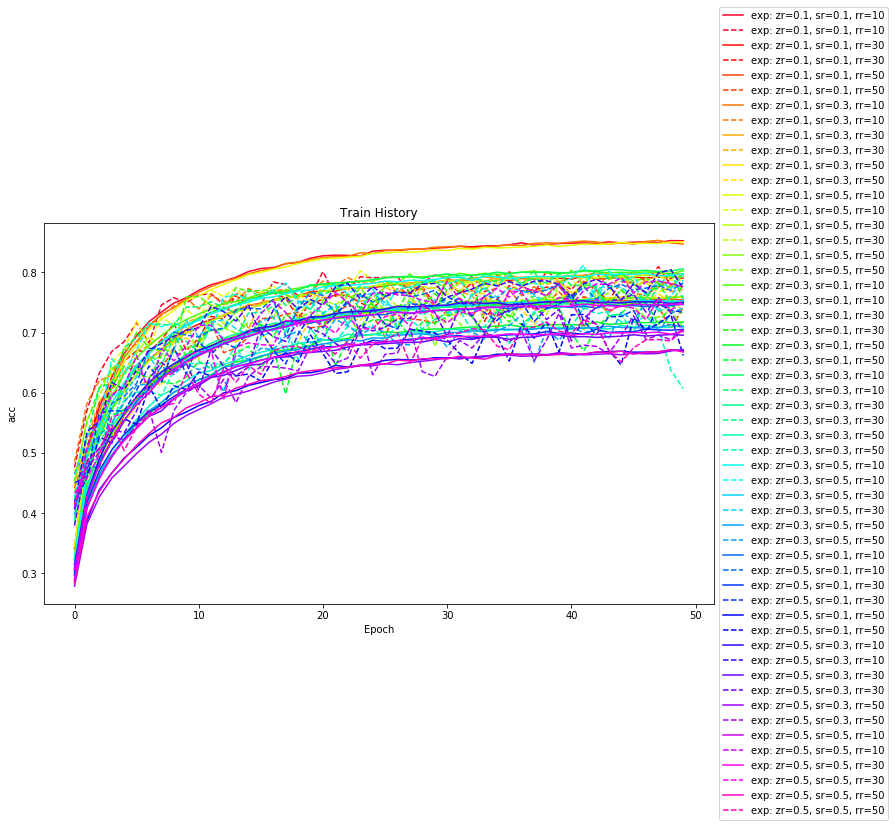

In [9]:
batch_trainer.display('acc', 'val_acc')

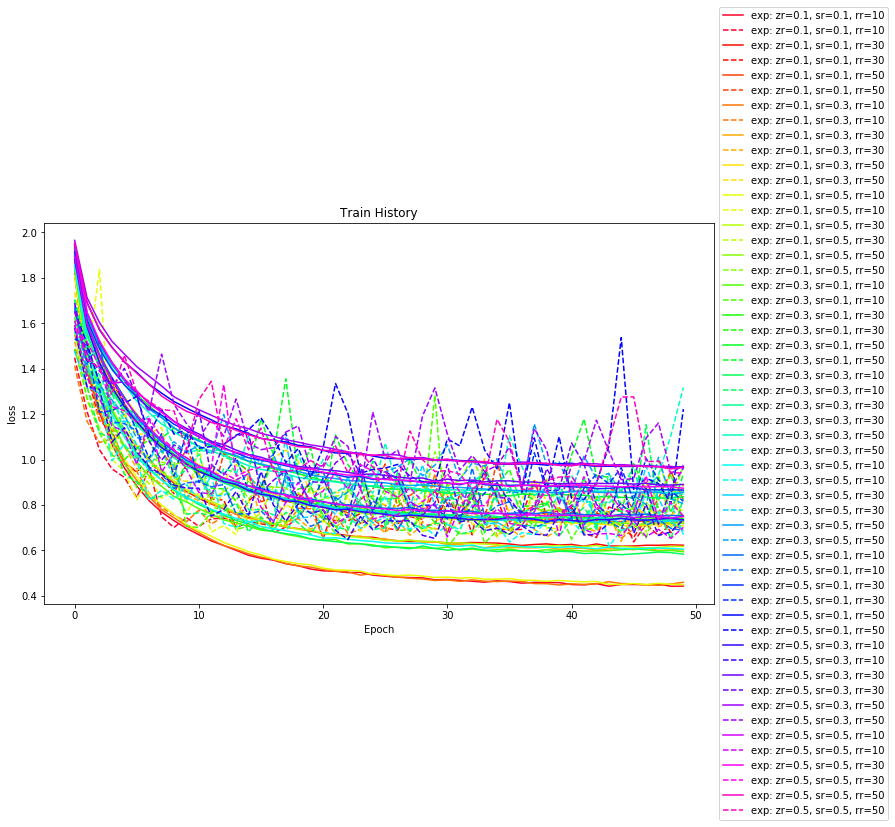

In [10]:
batch_trainer.display('loss', 'val_loss')